# Introduction


Рассматривается торговая стратегия основанная на дивидендных гэпах акций РФ. Для этого был собран и подготовлен датасет и проведено исследование.

**Датасет**
- состоит из дивидендных выплат акций РФ компаний, торгующихся на бирже, содержит такие параметры, как дата и размер выплаты, стоимость акции в окрестности выплаты, сроки закрытия гэпа
- Stack: T-invest API, MOEX API, BeautifulSoup (парсинг SmartLab)
- ручное редактирование ошибочных данных (некорректный размер или дата выплаты, сдвоенные выплаты, сплиты) с помощью InvestMint


**Торговая стратегия**
- заключается в покупке акций в день перед дивидендами и продажей их на следующий день
- на исторических данных прибыльна при малых торговых комиссиях (<0.2%) и отсутствии налога на дивиденды (только для фондов)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import datetime as dt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as mtick


# Data preparing

- Выплаты отсекаются по дате и объему торгов
- Рассчитываются параметры Доходность (он вычисляется как (Закрытие1 - Закрытие0 + Дивиденд)/(Закрытие0) * 100) и Индекс (изменение в процентах индекса Мосбиржи полной доходности за этот день)
- Убираются нерассматриваемые в данной задаче параметры по типу цен закрытия за неделю до и после выплаты


Итоговый датасет содержит следующие колонки:
- Тикер — биржевой тикер компании, выплачивающей дивиденды.
- Дивиденд, руб — размер объявленного дивиденда на одну акцию в рублях.
-Див. дох., % — дивидендная доходность в процентах (рассчитывается как отношение дивиденда к цене акции).
-Last buy day — последний торговый день, когда можно купить акцию с правом на получение дивиденда (т.е. день перед датой отсечки).
-Закрытие0 — цена акции на закрытие торгов в Last buy day.
-Открытие1 — цена открытия на следующий торговый день после отсечки (экс-дивидендная дата).
-Закрытие1 — цена закрытия на следующий торговый день после отсечки (экс-дивидендная дата).
-Гэп — абсолютное изменение цены между закрытием "последнего дня с дивидендами" и открытием следующего дня.
-Гэп, % — отношение Гэпа к размеру Дивидендов в процентах
-Гэп 2 — разница между ценами закрытия в день до и в день после дивидендов
-Гэп 2, % — отношение Гэпа2 к размеру Дивидендов в процентах
-Дата закрытия Гэпа — дата, когда цена закрытия восстановилась до уровня до дивидендного гэпа (если такое произошло).
-Дней до закрытия Гэпа — количество дней, потребовавшихся для восстановления цены до уровня до дивидендного гэпа.
-Объём, руб — высчитывается как минимальный торговый объём в рублях в один из двух рассматриваемых торговых дней (нужен для отсечки ликвидных акций)
-Индекс, % — изменение в процентах индекса Мосбиржи полной доходности за этот день
-Доходность % — (Закрытие1 - Закрытие0 + Дивиденд)/(Закрытие0) * 100)



In [2]:
df_dividends_0= pd.read_excel('divs_calculated_.xlsx')
df_dividends_0['Объём, руб'] = np.minimum(df_dividends_0["Закрытие0"]*df_dividends_0["Объём0"], df_dividends_0["Закрытие1"]*df_dividends_0["Объём1"])
df_dividends_0 = df_dividends_0.drop(columns=["Объём0", "Объём1","Купить до","Платеж до (S)"," Платеж (T)","Источник"])

#Отсечем по датам и объему
df_dividends = df_dividends_0[df_dividends_0['Last buy day']>dt.datetime(2015, 1, 1)].copy()
Value = 5e8    # ваш порог
df_dividends = df_dividends[df_dividends['Объём, руб']>=Value]
df_dividends["Доходность"] = 1/ df_dividends['Закрытие0'] * (df_dividends['Закрытие1']-df_dividends['Закрытие0'] + df_dividends['Дивиденд, руб']) * 100
df_dividends["Индекс, %"] = (df_dividends['Индекс1']/df_dividends['Индекс0']-1)*100

cols_to_drop = ['Закрытие-14',
    'Закрытие-7', 'Закрытие-3', 'Закрытие-2', 'Закрытие-1',
    'Закрытие2', 'Закрытие3', 'Закрытие4', 'Закрытие5',
    'Закрытие6', 'Закрытие7',
    'Индекс-14', 'Индекс-7', 'Индекс-3', 'Индекс-2',
    'Индекс-1', 'Индекс0', 'Индекс1', 'Индекс2',
    'Индекс3', 'Индекс4', 'Индекс5', 'Индекс6', 'Индекс7'
]

df_dividends = df_dividends.drop(columns=cols_to_drop, errors='ignore')
df_dividends = df_dividends[~df_dividends['Тикер'].isin(['OKEY', 'AKRN'])]
rename_dict = {
    'Тикер': 'Ticker',
    'Дивиденд, руб': 'Dividend, RUB',
    'Див. дох., %': 'Dividend Yield, %',
    'Last buy day': 'Last Buy Day',
    'Закрытие0': 'Close',
    'Открытие1': 'Open-ex',
    'Закрытие1': 'Close-ex',
    'Гэп': 'Gap',
    'Гэп, %': 'Gap, %',
    'Гэп 2': 'Gap Adj',
    'Гэп 2, %': 'Gap Adj, %',
    'Дата закрытия Гэпа': 'Gap Close Date',
    'Дней до закрытия Гэпа': 'Days to Gap Close',
    'Объём, руб': 'Volume, RUB',
    'Доходность': 'Profit',
    'Индекс, %': 'Index, %'
}

# Переименование
df_dividends.rename(columns=rename_dict, inplace=True)

df_dividends.tail()


,Ticker,"Dividend, RUB","Dividend Yield, %",Last Buy Day,Close,Open-ex,Close-ex,Gap,"Gap, %",Gap Adj,"Gap Adj, %",Gap Close Date,Days to Gap Close,"Volume, RUB",Profit,"Index, %"
1565,TRNFP,198.25,13.225484,2025-07-16,1499.00,1340.00,1306.00,159.00,80.201765,193.00,97.351828,NaT,NaN,3.709745e+09,0.350233,0.059711
1566,AFLT,5.27,8.509608,2025-07-17,61.93,57.50,60.13,4.43,84.060721,1.80,34.155598,2025-08-07,19.0,1.961221e+09,5.603100,2.756905
1567,ROSN,14.68,3.489422,2025-07-17,420.70,406.00,414.35,14.70,100.136240,6.35,43.256131,2025-07-19,2.0,1.916655e+09,1.980033,2.756905
1568,SBER,34.84,10.652805,2025-07-17,327.05,300.45,309.00,26.60,76.349024,18.05,51.808266,NaT,NaN,2.982108e+10,5.133772,2.756905
1569,SBERP,34.84,10.748110,2025-07-17,324.15,297.00,308.40,27.15,77.927669,15.75,45.206659,NaT,NaN,2.760585e+09,5.889249,2.756905


# EDA


In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl

FIG_W, FIG_H = 4.5, 3
DPI = 300
FONT = 'DejaVu Sans'
TITLE_SIZE = 10
LABEL_SIZE = 6
TICK_SIZE =6
LEGEND_SIZE = 6
LINE_WIDTH = 1.5
MARKER_SIZE = 4
GRID_ALPHA = 0.2
PALETTE = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

mpl.rcParams.update({
    'figure.figsize': (FIG_W, FIG_H),
    'figure.dpi': DPI,
    'savefig.dpi': DPI,
    'font.family': FONT,
    'axes.titlesize': TITLE_SIZE,
    'axes.labelsize': LABEL_SIZE,
    'xtick.labelsize': TICK_SIZE,
    'ytick.labelsize': TICK_SIZE,
    'legend.fontsize': LEGEND_SIZE,
    'axes.grid': True,
    'grid.alpha': GRID_ALPHA,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.titleweight': 'semibold',
    'lines.linewidth': LINE_WIDTH,
    'lines.markersize': MARKER_SIZE,
})
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=PALETTE)

Path('pics').mkdir(exist_ok=True)

def save_pic(name):
    plt.savefig(f'pics/{name}.png', bbox_inches='tight', facecolor='white')


### Base stats

In [4]:
pd.options.display.float_format = '{:,.2f}'.format
num_cols = df_dividends.select_dtypes(include=np.number).columns
display(df_dividends[num_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
"Dividend, RUB",333.00,60.44,117.97,0.01,5.80,18.07,45.94,907.00
"Dividend Yield, %",333.00,5.62,4.67,0.48,2.83,4.51,6.87,48.95
Close,333.00,"1,354.79","2,278.45",0.16,115.35,346.95,"1,115.00","11,730.00"
Open-ex,333.00,"1,305.14","2,213.52",0.15,109.00,328.80,"1,072.30","11,730.00"
Close-ex,333.00,"1,303.24","2,213.20",0.16,110.60,328.65,"1,059.60","11,667.00"
Gap,333.00,49.65,94.97,-38.00,4.50,14.00,39.00,531.00
"Gap, %",333.00,83.50,20.28,-89.83,77.22,86.20,92.14,173.56
Gap Adj,333.00,51.55,111.31,-189.00,3.91,12.50,38.90,922.00
"Gap Adj, %",333.00,81.92,61.83,-236.41,60.22,81.04,106.84,378.38
Days to Gap Close,284.00,59.28,114.61,1.00,5.00,17.50,59.50,784.00


### Сorrelation matrix

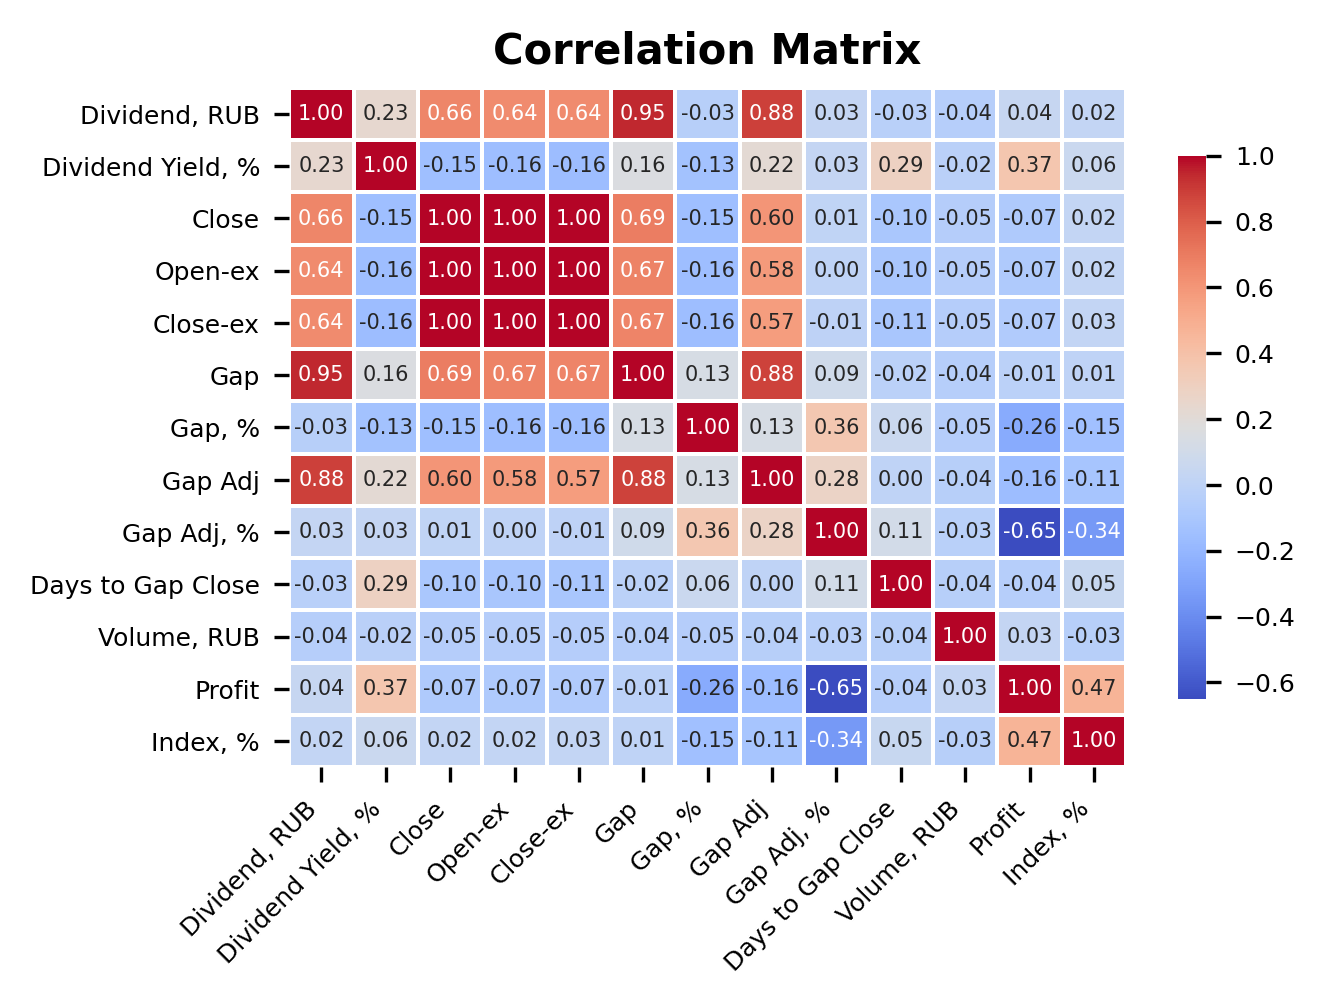

In [5]:
numeric_df = df_dividends.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()

plt.figure()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar_kws={"shrink": 0.8},annot_kws={'size': 5})
plt.title("Correlation Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
save_pic('correlation_matrix')
plt.show()


### Different distributions:

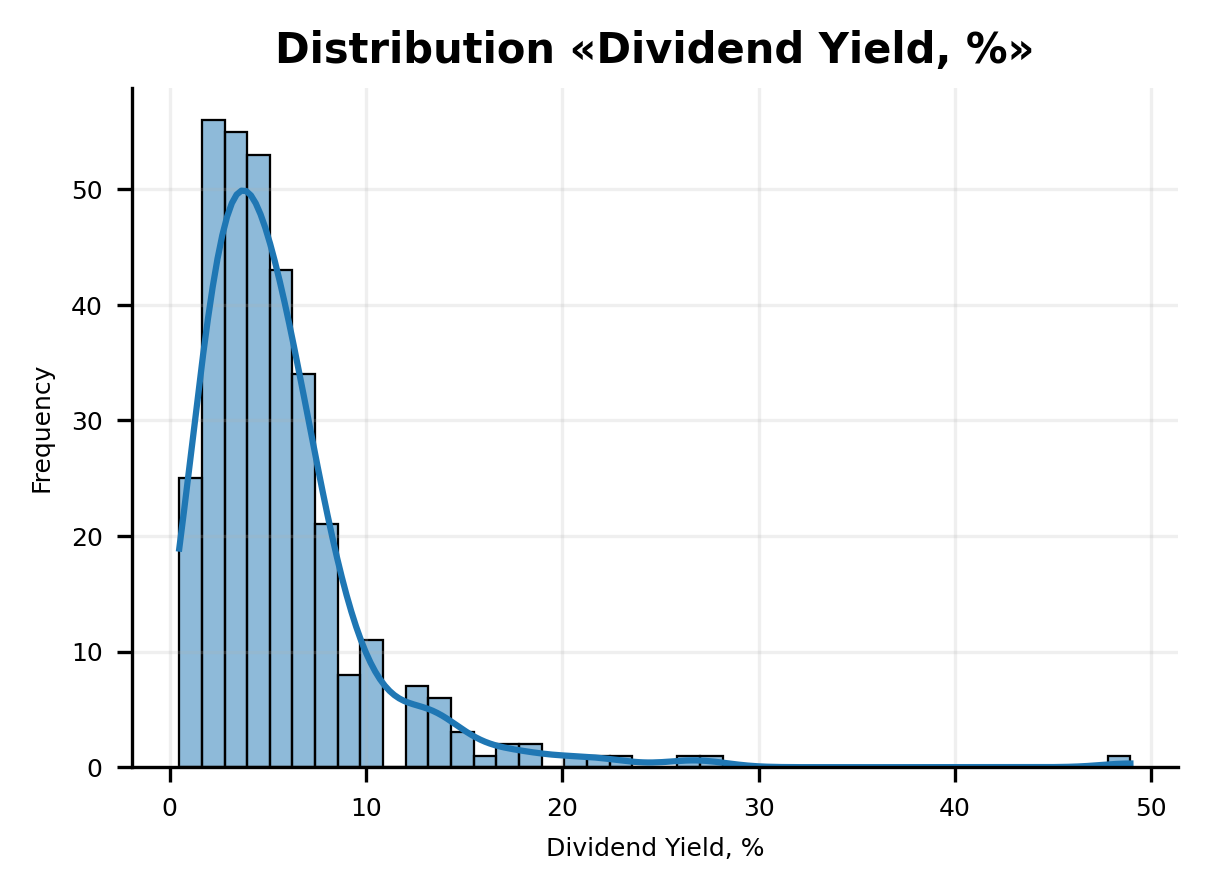

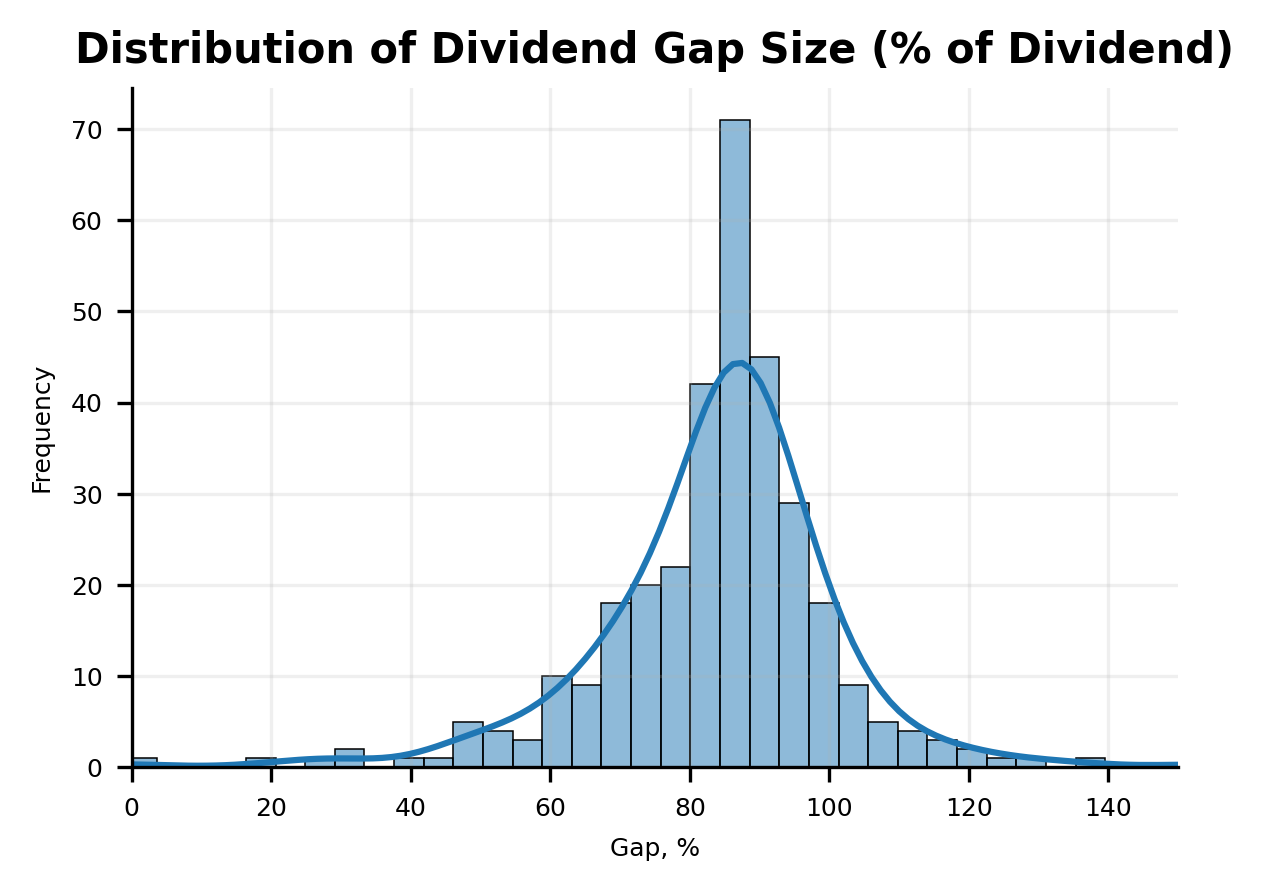

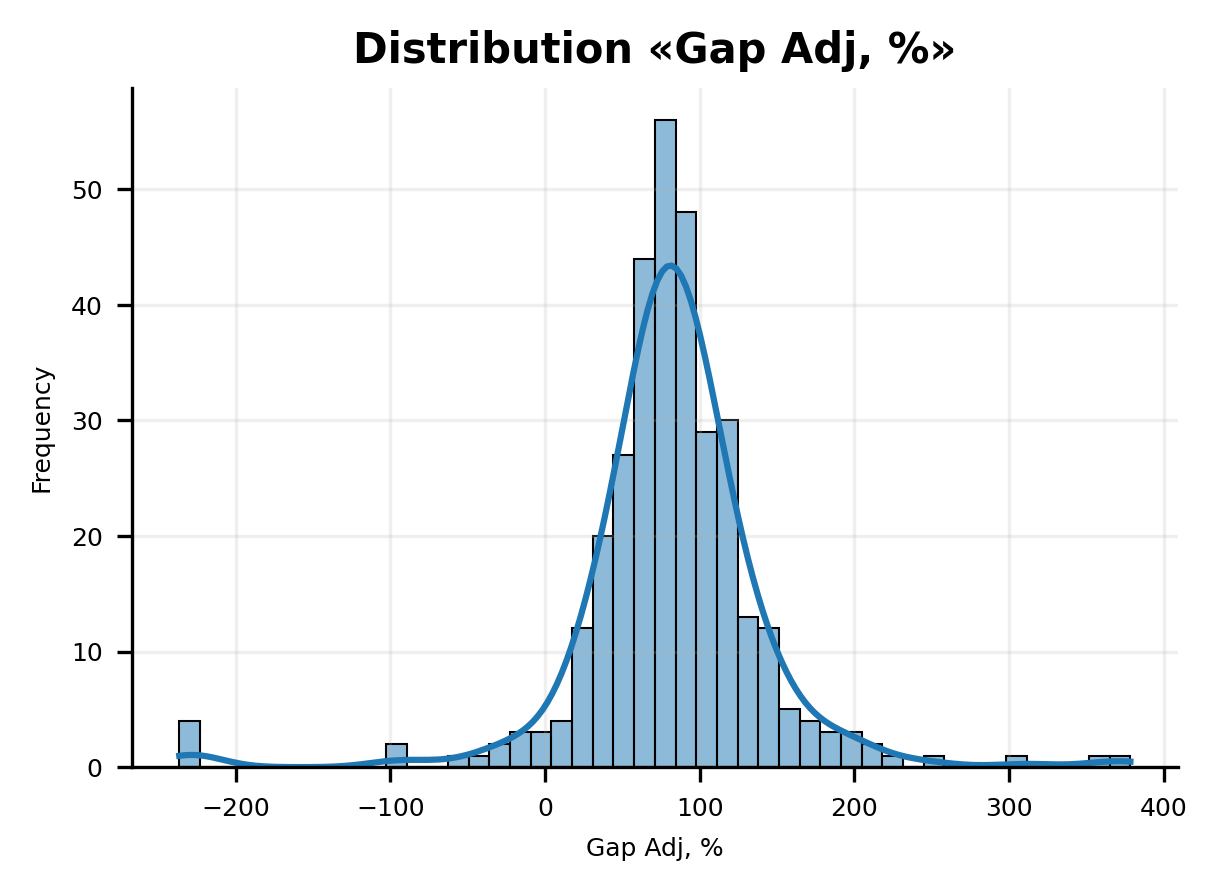

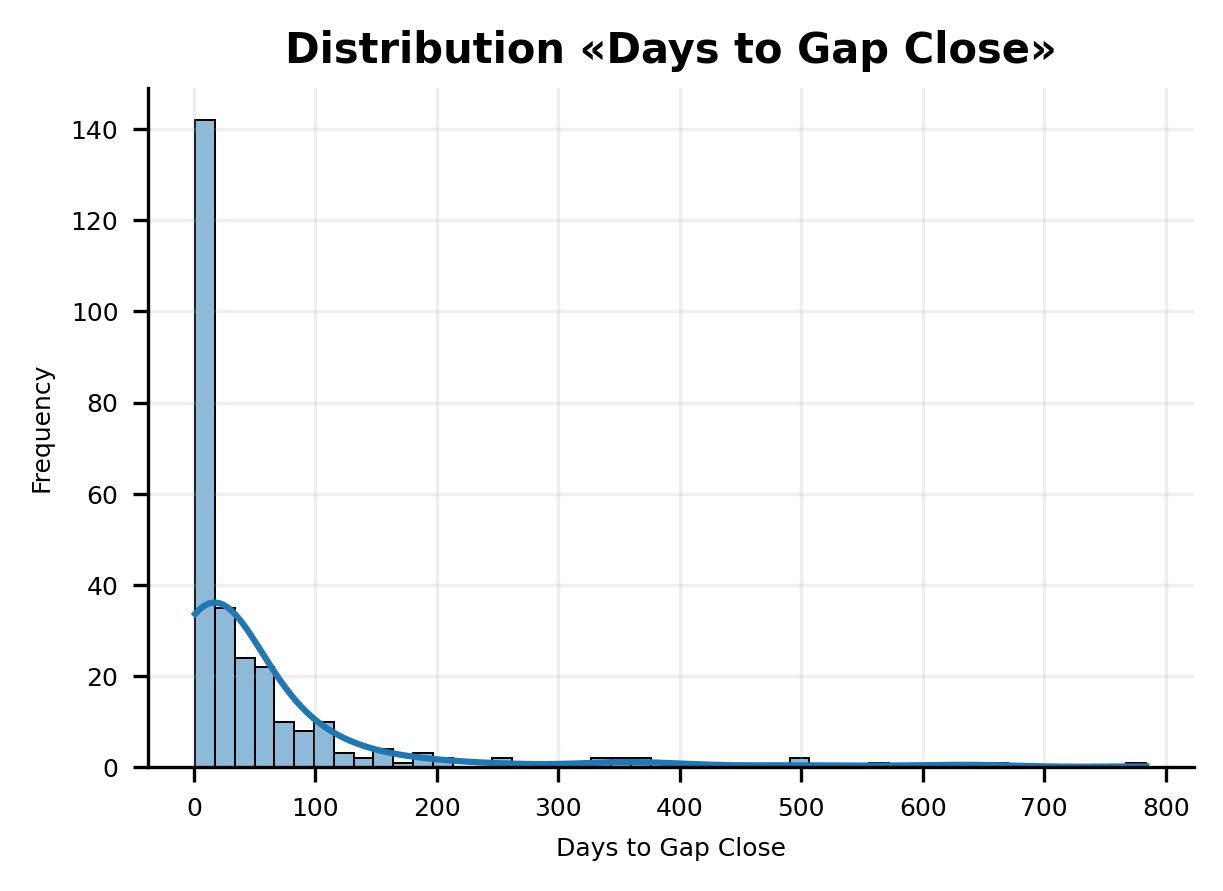

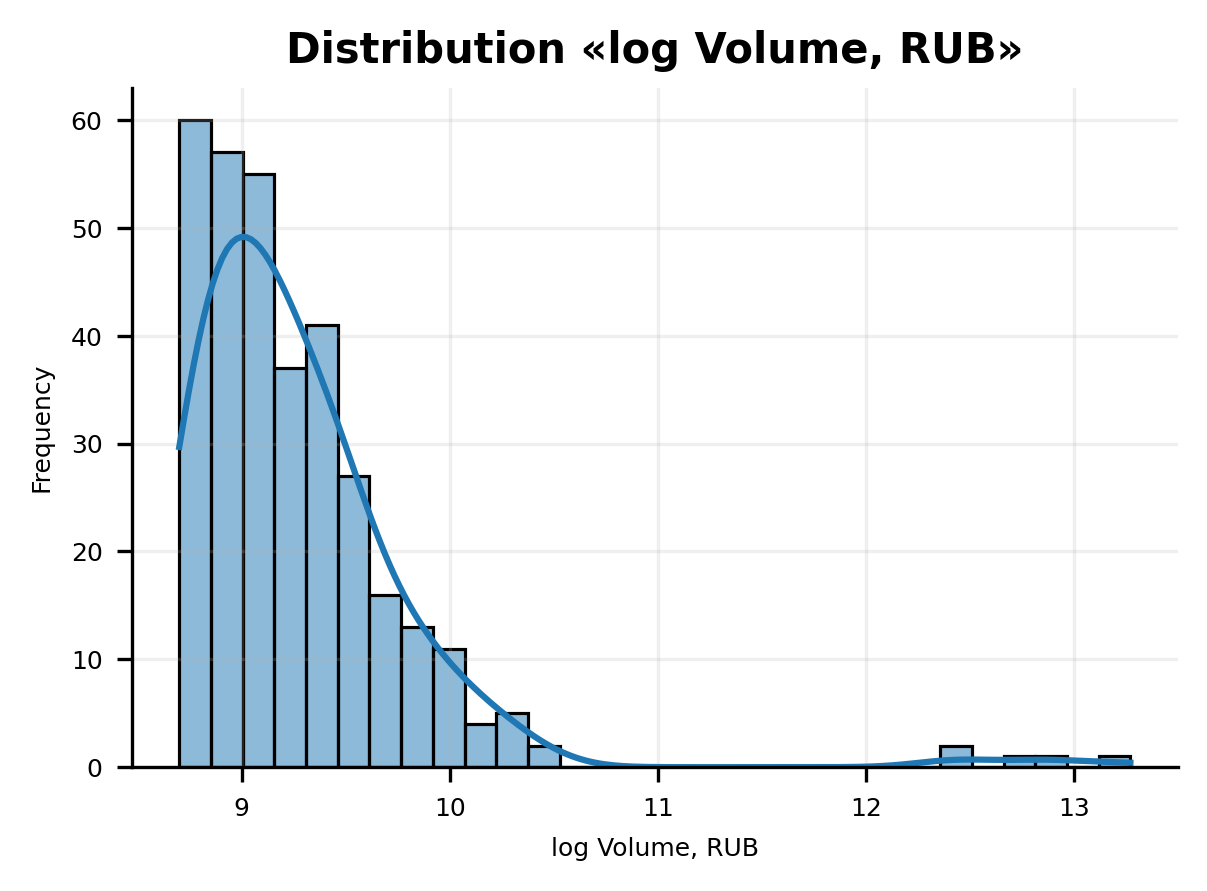

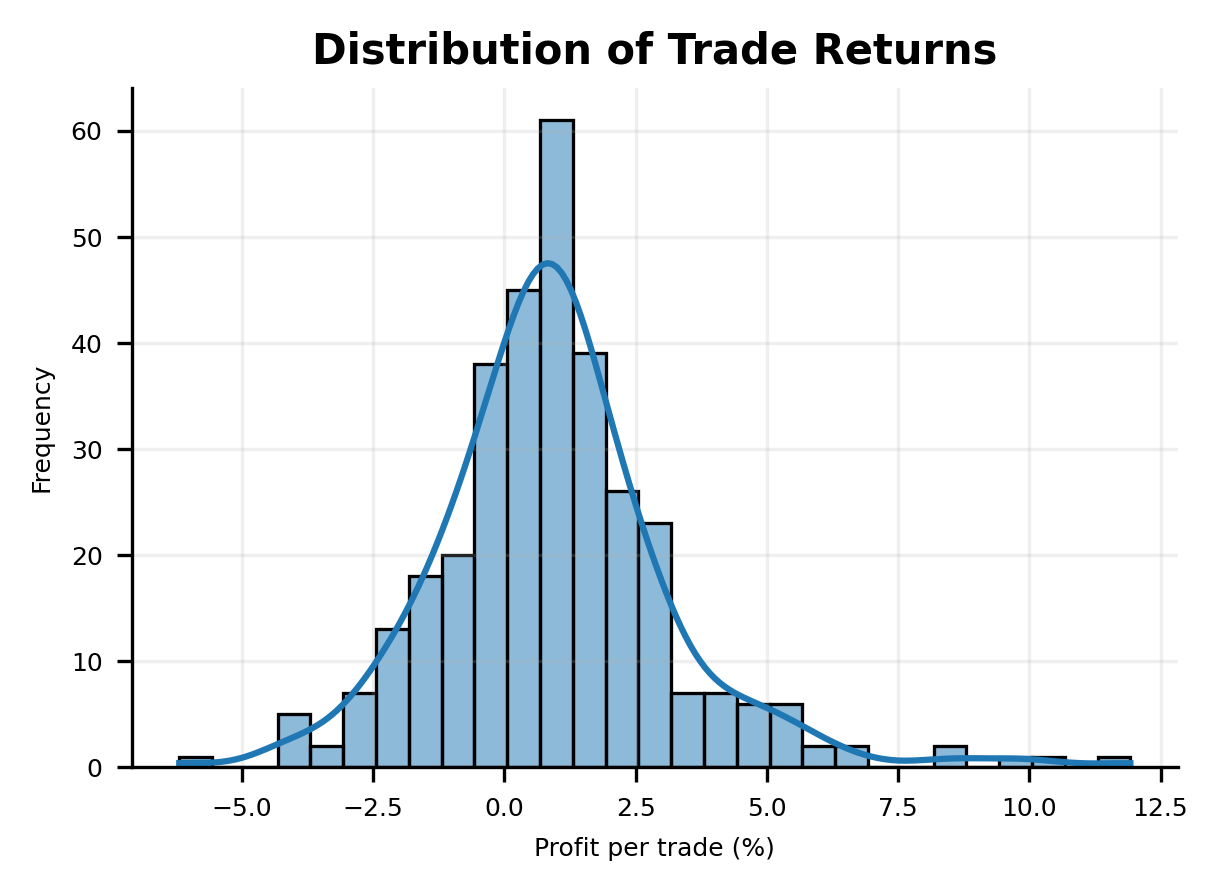

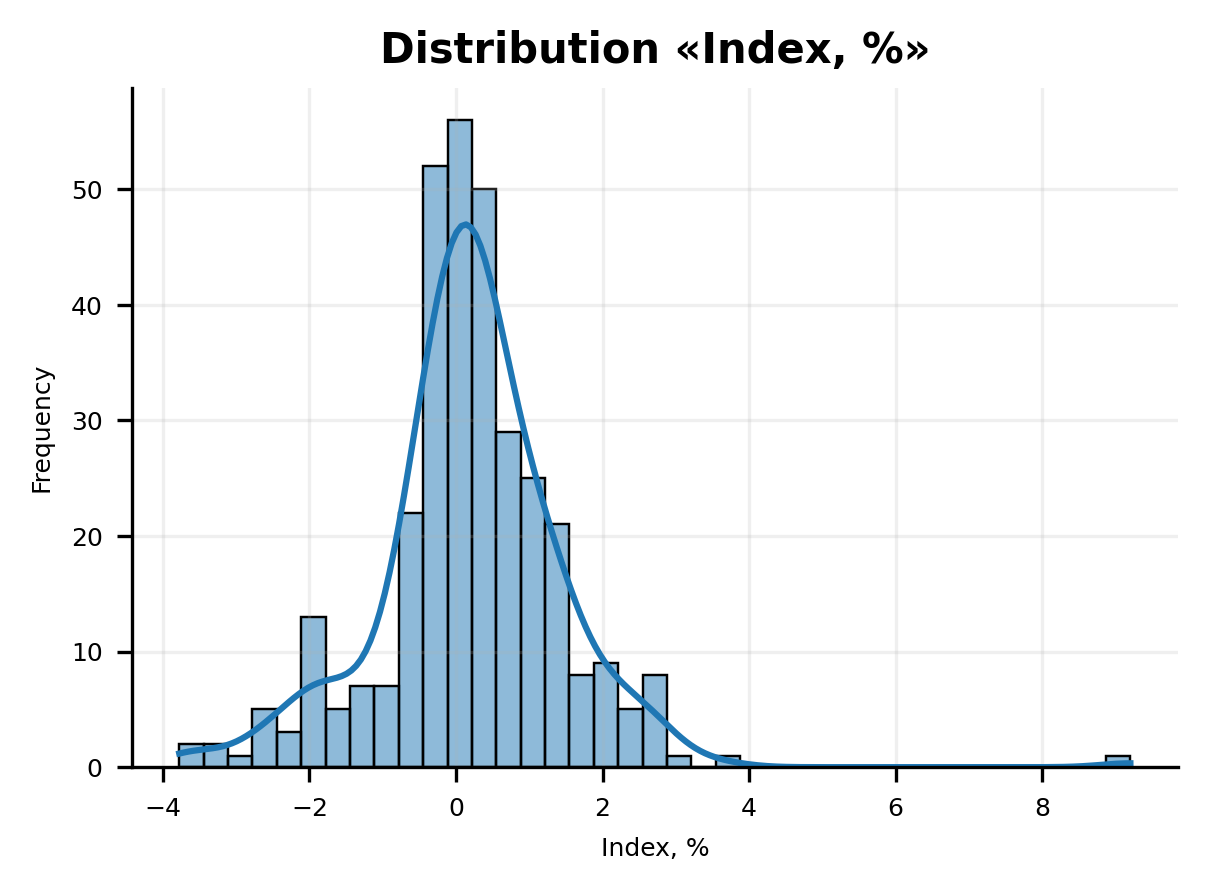

In [6]:
num_cols2 = [
    'Dividend Yield, %',
    'Gap, %',
    'Gap Adj, %',
    'Days to Gap Close',
    'Volume, RUB',
    'Profit',
    'Index, %'
]

gap_xlim = (0, 150)  

for col in num_cols2:
    s = df_dividends[col].dropna()
    x = np.log10(s) if col == 'Volume, RUB' else s

    plt.figure()
    ax = sns.histplot(x, kde=True, bins='auto')
    kde_line = [line for line in ax.get_lines() if line.get_label() == 'KDE']
    if kde_line:
        xs = kde_line[0].get_xdata()
        ys = kde_line[0].get_ydata()
        center_peak = xs[np.argmax(ys)]
        print(f"{col}: mid ≈ {center_peak:.3f}")

    

    ax.set_title(
        f"Distribution «log {col}»" if col == 'Volume, RUB' else f"Distribution «{col}»",
        pad=6
    )
    if col == 'Gap, %':
        ax.set_xlim(gap_xlim)
        ax.set_title("Distribution of Dividend Gap Size (% of Dividend)")
    
        
    ax.set_xlabel(f"log {col}" if col == 'Volume, RUB' else col)
    ax.set_ylabel('Frequency')
    if col == 'Profit':
        ax.set_title("Distribution of Trade Returns")
        ax.set_xlabel("Profit per trade (%)")
    save_pic(f"distribution_{'log_' if col == 'Volume, RUB' else ''}{col}")
    plt.show()


### Distribution of payments by quarter:

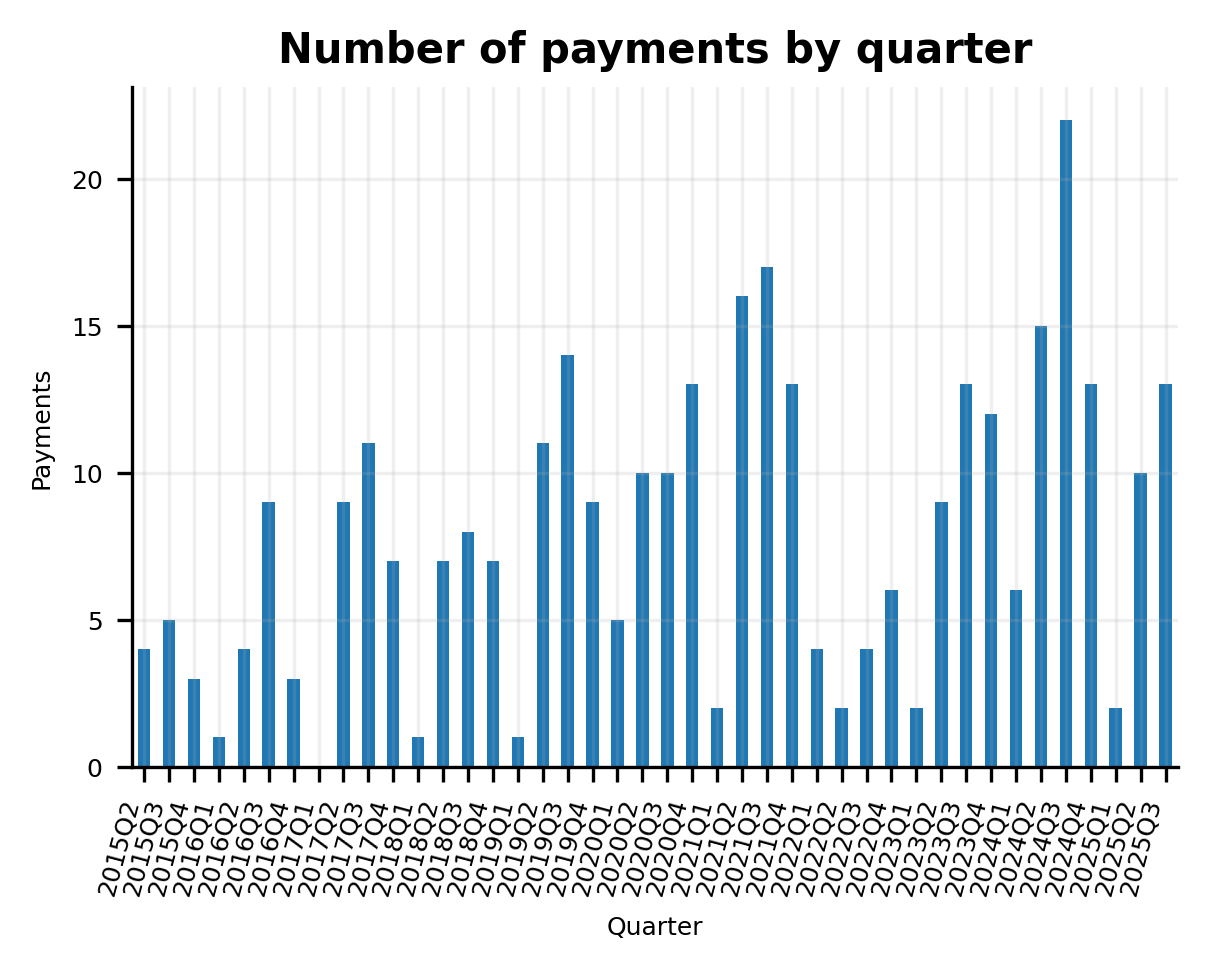

Average number of transactions by quarter:


Quarter
1    2.40
2    8.82
3   11.45
4    8.60
Name: Payments, dtype: float64

In [7]:
df_dividends['Last Buy Day'] = pd.to_datetime(df_dividends['Last Buy Day'], errors='coerce')
quarterly_counts = df_dividends.set_index('Last Buy Day').resample('Q').size()
quarterly_counts.index = quarterly_counts.index.to_period('Q')

plt.figure()
ax = quarterly_counts.plot(kind='bar')
ax.set_title('Number of payments by quarter')
ax.set_xlabel('Quarter')
ax.set_ylabel('Payments')
ax.set_xticklabels(ax.get_xticklabels(), rotation=75, ha='right')
save_pic('payments_by_quarter')
plt.show()

quarterly_counts_df = quarterly_counts.to_frame(name='Payments')
quarterly_counts_df['Quarter'] = quarterly_counts_df.index.quarter
avg_per_quarter = quarterly_counts_df.groupby('Quarter')['Payments'].mean()

print("Average number of transactions by quarter:")
display(avg_per_quarter)


### Distribution of relative Gaps (the ratio of the gap value to the dividend value):
- Close-Open or the usual Gap between the closing price and the opening price on the cut-off day, a narrow distribution centered at about 87% (income tax 13%)
- Close-Close or Gap 2 between the closing price and the closing price on the cut-off day

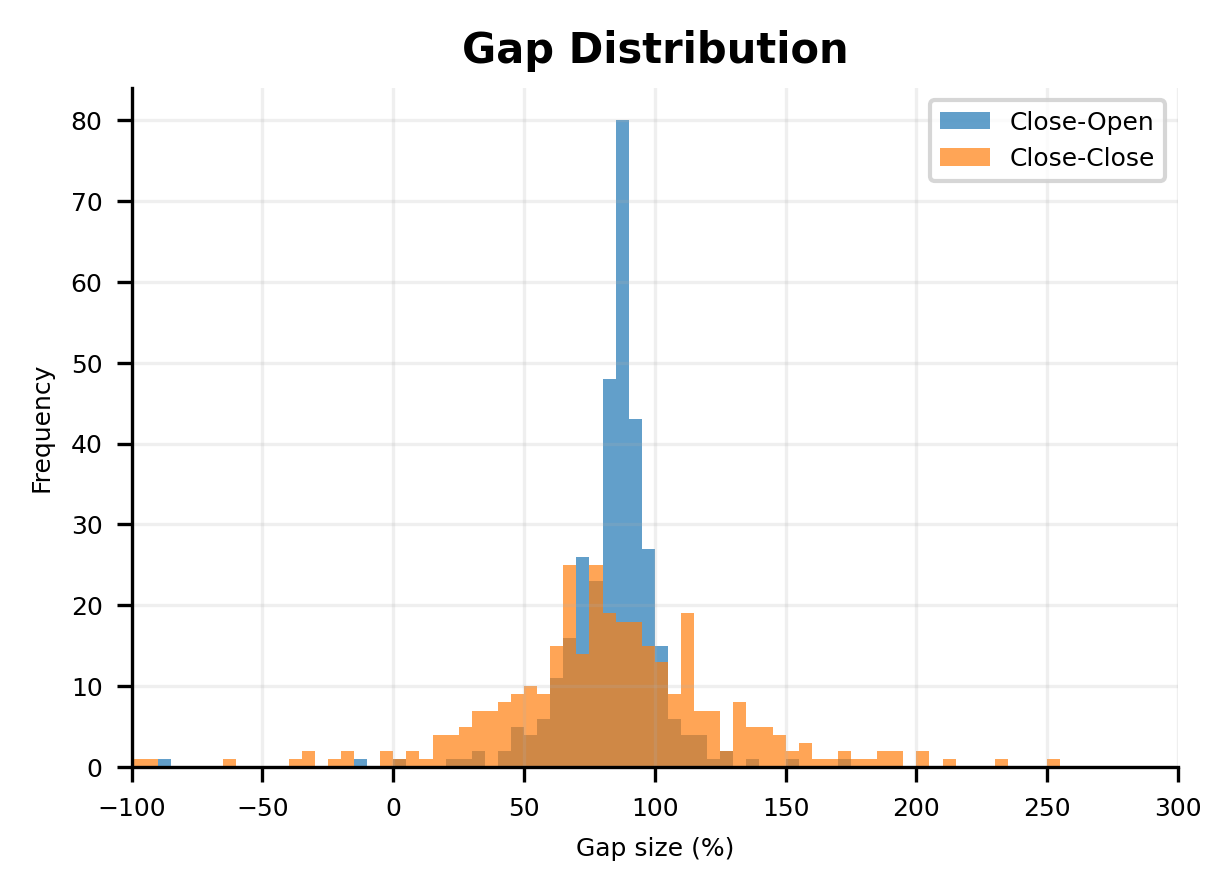

In [8]:
edges = np.arange(-300, 501, 5)
plt.figure()
plt.hist(df_dividends['Gap, %'].dropna(), bins=edges, alpha=0.7, label='Close-Open')
plt.hist(df_dividends['Gap Adj, %'].dropna(), bins=edges, alpha=0.7, label='Close-Close')
plt.xlabel('Gap size (%)')
plt.ylabel('Frequency')
plt.title('Gap Distribution')
plt.xlim([-100, 300])
plt.legend()
save_pic('gap_distribution_en')
plt.show()

### Comparison of relative Gap and dividend yield
There is hyperbole, the physical meaning of which is to limit the percentage drop in the stock price by 10%

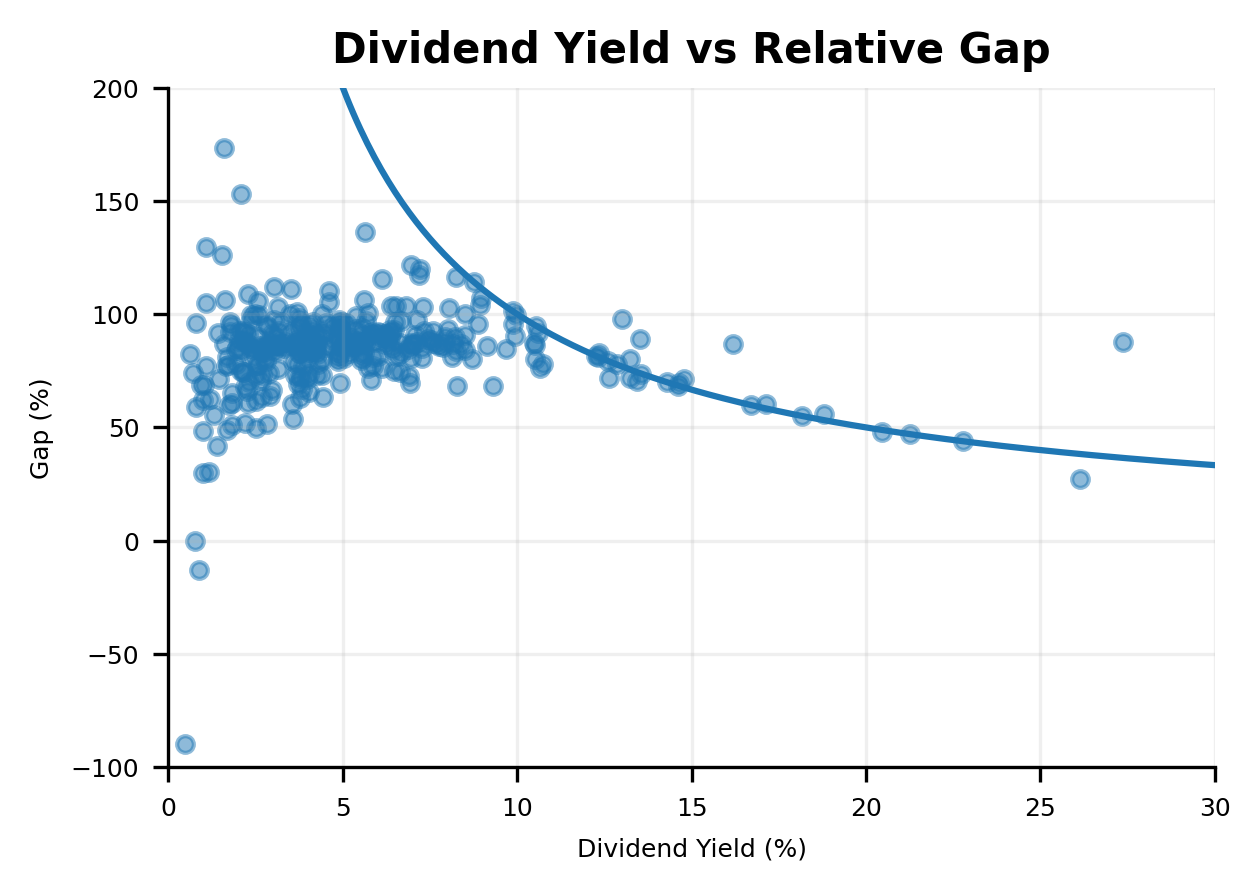

In [9]:
plt.figure()
plt.scatter(df_dividends['Dividend Yield, %'], df_dividends['Gap, %'], alpha=0.5)
plt.plot(np.arange(1, 40, 0.1), 1000 / np.arange(1, 40, 0.1))
plt.title('Dividend Yield vs Relative Gap')
plt.xlabel('Dividend Yield (%)')
plt.ylabel('Gap (%)')
plt.xlim([0, 30])
plt.ylim([-100, 200])
save_pic('div_yield_vs_gap')
plt.show()


### Comparison of relative Gap 2 (closing price difference) and dividend yield
There is no hyperbole, the distribution is more normal

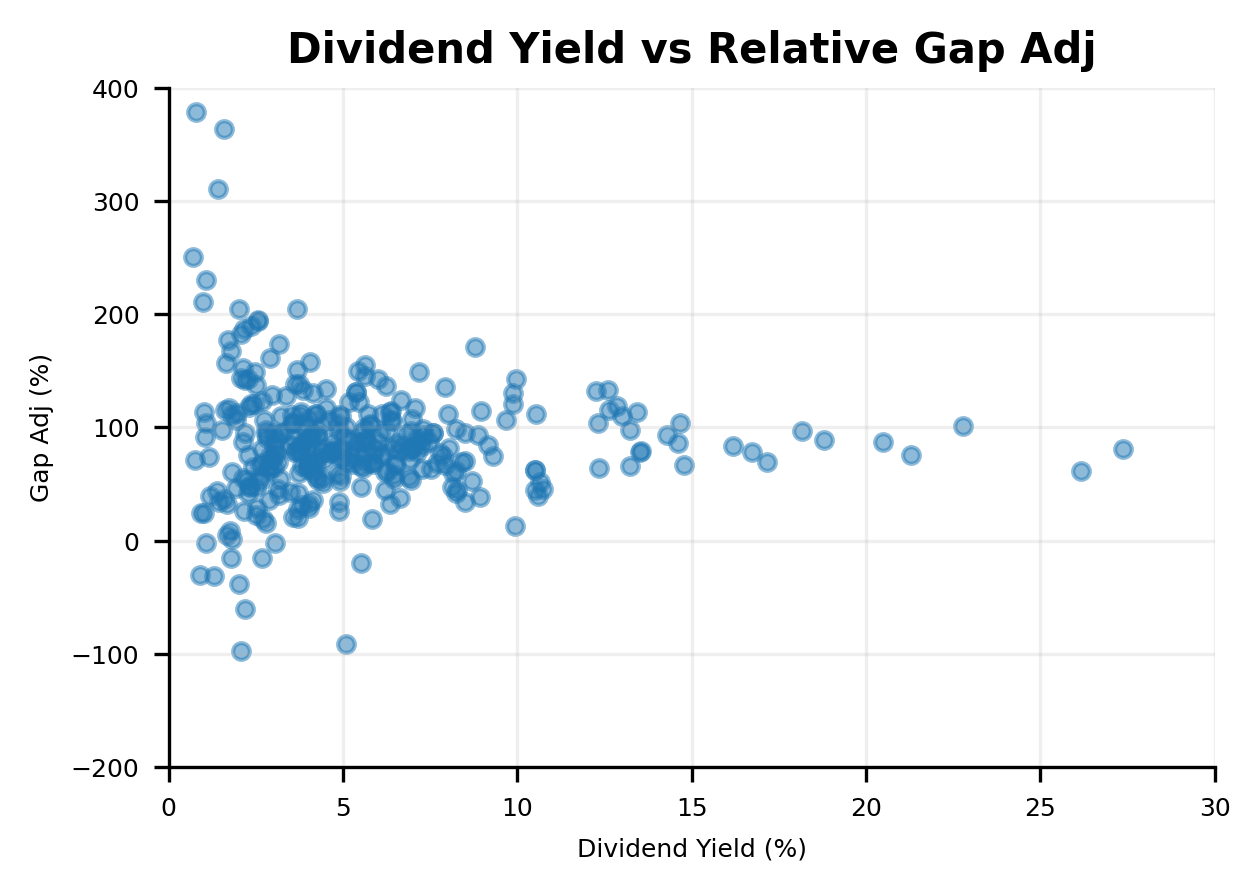

In [10]:
plt.figure()
plt.scatter(df_dividends['Dividend Yield, %'], df_dividends['Gap Adj, %'], alpha=0.5)
plt.title('Dividend Yield vs Relative Gap Adj')
plt.xlabel('Dividend Yield (%)')
plt.ylabel('Gap Adj (%)')
plt.xlim([0, 30])
plt.ylim([-200, 400])
save_pic('div_yield_vs_gap2')
plt.show()


### Closing dates of the gap

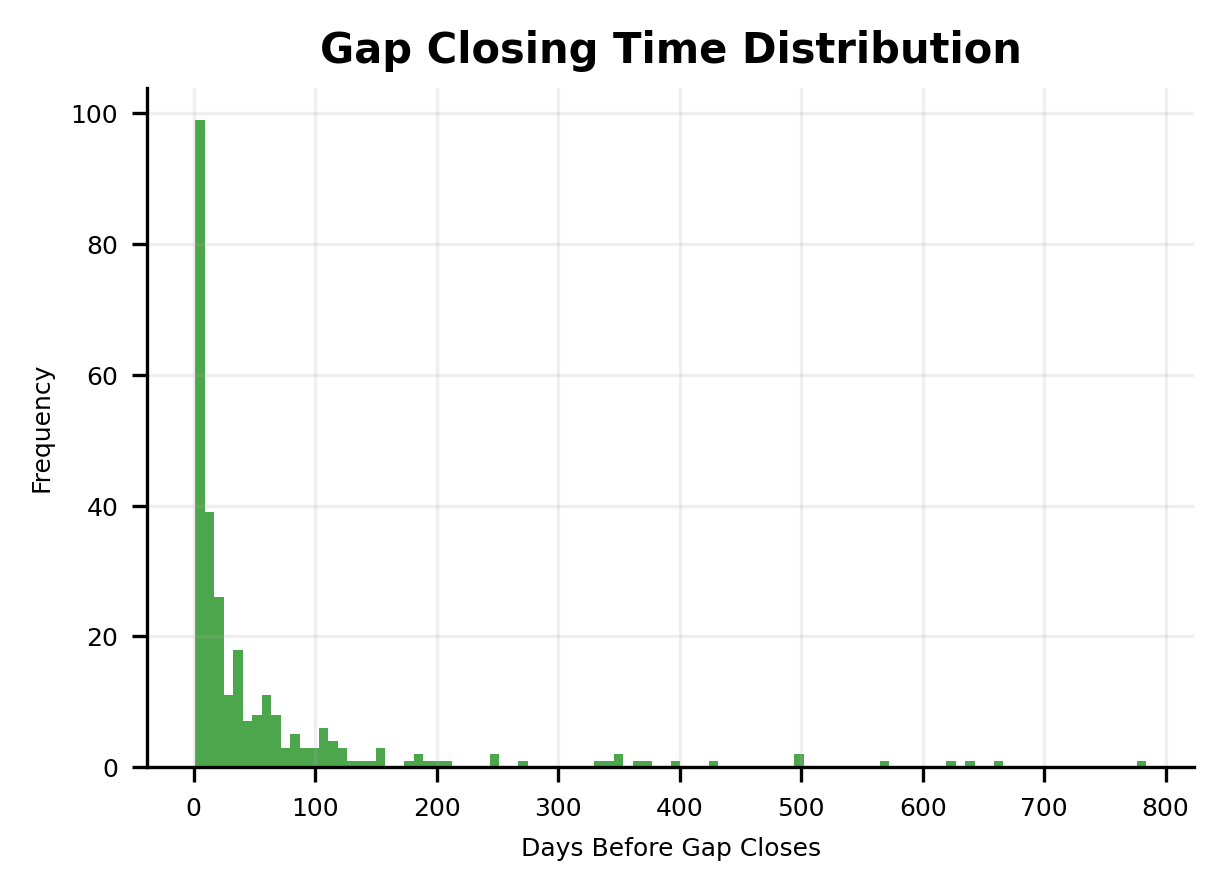

In [11]:
plt.figure()
plt.hist(df_dividends['Days to Gap Close'].dropna(), bins=100, color='green', alpha=0.7)
plt.xlabel('Days Before Gap Closes')
plt.ylabel('Frequency')
plt.title('Gap Closing Time Distribution')
save_pic('gap_closing_time_distribution')
plt.show()


# Formulation of the backtest strategy and parameters
On each date when there is a dividend payment, buy the necessary shares from the dataset in equal shares in the amount of 1 M rubles at the Closing price, and the next day sell the entire position at the Closing price of 2. For this, only liquid shares with a daily trading volume of 500 M were selected. For simplicity, it is assumed that the dividends come on the same day.

The tax on dividends is 0%, the transaction fee is taken into account (the base scenario is 0.02% per transaction).

A strategy was chosen as a **benchmark**, in which the Moscow Exchange index of full profitability was bought for similar amounts on similar dates. This makes it possible to distinguish the growth of the strategy from the growth of the market as a whole.

In [12]:
"""dividend_strategy_simulation.py
=================================
Simulation of a one‑day dividend‑capture strategy for the Russian equity market.

Business rules
--------------
* **Independent capital** – each *ex‑div* date starts with exactly **1 000 000 RUB**.  
  If *k* tickers go ex‑div the same day, that million is split equally
  (≈ 1 000 000 / k per ticker).
* **Timeline per position**
  * **D‑0** (`Last Buy Day`) – buy at Close(close price).  
  * **D+1** –
    1. sell at Close-ex (next‑day close),
    2. pay commission on both legs, then
    3. credit cash dividends for yesterday’s shares.
  * Profit of that trade is recorded on **D+1**.

The module exposes four top‑level helpers:
* `simulate_strategy(df, commission=0.0002, capital_per_day=1_000_000)`
* `plot_cumulative_profit(hist_df, ax=None)`
* `compute_stats(trades_df, rf=0.0)` – average P&L, max win/loss, streaks, PF, Sharpe
* `save_log(trades_df, path='operations_log.xlsx')`
"""
from __future__ import annotations

import math
from datetime import timedelta
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

__all__ = [
    "simulate_strategy",
    "plot_cumulative_profit",
    "compute_stats",
    "save_log",
]

# ---------------------------------------------------------------------------
# Core simulation
# ---------------------------------------------------------------------------

def simulate_strategy(
    df: pd.DataFrame,
    *,
    commission: float = 0.0002,
    capital_per_day: float = 1_000_000.0,
    buy_col: str = "Last Buy Day",
    close_col: str = "Close",
    next_close_col: str = "Close-ex",
    div_col: str = "Dividend, RUB",
    ticker_col: str = "Ticker",
    bench_col : str = "Index, %"
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Run the day‑after dividend capture simulation.

    Parameters
    ----------
    df : pd.DataFrame
        Source dataset with the required columns.
    commission : float, default 0.0002 (0.02 %)
        Broker commission per *turnover* (applied to cost and proceeds).
    capital_per_day : float, default 1_000_000
        How much cash is allocated *per trading day* ― **not** rolled.
    Returns
    -------
    trades_df : detailed log of every BUY / SELL / DIV in money terms.
    hist_df   : time‑series of daily and cumulative profit.
    """
    df = df.copy()
    df[buy_col] = pd.to_datetime(df[buy_col])

    results: list[dict] = []

    for buy_date, group in df.groupby(buy_col):
        k = len(group)
        if k == 0:
            continue
        capital_each = capital_per_day / k

        for _, row in group.iterrows():
            ticker = row[ticker_col]
            buy_price = float(row[close_col])
            sell_price = float(row[next_close_col])
            dividend = float(row[div_col])
            bench = float(row[bench_col])

            # Fractional shares allowed for simplicity
            # Покупаем ровно на capital_each (комиссия уже внутри)
            shares     = capital_each / (buy_price * (1 + commission))  # ≤ capital_each
            buy_cost   = shares * buy_price
            buy_comm   = buy_cost * commission                          # для логов
            sell_value = shares * sell_price
            sell_comm  = sell_value * commission
            div_income = shares * dividend
            profit = sell_value - capital_each - sell_comm + div_income
            bench_profit = capital_each*(bench/100)
            results.append({
                "ticker": ticker,
                "buy_date": buy_date,
                "sell_date": buy_date + timedelta(days=1),
                "capital": capital_each,
                "shares": shares,
                "buy_price": buy_price,
                "sell_price": sell_price,
                "dividend_per_share": dividend,
                "profit": profit,
                "bench_profit":bench_profit,
            })

    trades_df = (
        pd.DataFrame(results)
        .sort_values("sell_date")
        .reset_index(drop=True)
    )

    # Daily aggregation on the sell/settlement date
    daily_profit = trades_df.groupby("sell_date", sort=True)["profit"].sum()
    daily_bench_profit = trades_df.groupby("sell_date", sort=True)["bench_profit"].sum()
    hist_df = pd.DataFrame({
        "date": daily_profit.index,
        "daily_profit": daily_profit.values,
        "daily_bench_profit": daily_bench_profit.values
    })
    hist_df["cumulative_profit"] = hist_df["daily_profit"].cumsum()
    hist_df["cumulative_bench_profit"] = hist_df["daily_bench_profit"].cumsum()

    return trades_df, hist_df



def plot_cumulative_profit(hist_df: pd.DataFrame, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.step(hist_df["date"], hist_df["cumulative_profit"], where="post", label='Strategy')
    ax.step(hist_df["date"], hist_df["cumulative_bench_profit"], where="post", label='1-Day MCFTR Benchmark')

    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Profit, RUB")
    ax.set_title("Dividend-Capture Strategy Performance")

    # формат оси Y: без научной записи, с разделителем тысяч
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:,.0f}"))

    ax.legend()
    save_pic('cumulative_profit')
    return ax

# ---------------------------------------------------------------------------
# Performance statistics
# ---------------------------------------------------------------------------

def compute_stats(
    trades_df: pd.DataFrame,
    hist_df: pd.DataFrame,
    rf_annual: float = 0.0,
    resample_freq: str = "B",
) -> pd.Series:
    if trades_df.empty:
        raise ValueError("`trades_df` must not be empty")

    # ---------------------------------------------------------------------
    # 1 .  Per‑trade statistics (order of trades, not time series)
    # ---------------------------------------------------------------------
    profits = trades_df["profit"].to_numpy(float)
    capital = trades_df["capital"].to_numpy(float)

    returns_per_trade = profits / capital

    gross_profit = profits[profits > 0].sum()
    gross_loss = profits[profits < 0].sum()

    wins = int((profits > 0).sum())
    losses = int((profits < 0).sum())

    avg_profit = gross_profit / wins if wins else 0.0
    avg_loss = gross_loss / losses if losses else 0.0

    # win / lose streaks --------------------------------------------------
    win_streak = lose_streak = streak = 0
    for p in profits:
        if p > 0:
            streak = streak + 1 if streak >= 0 else 1
        elif p < 0:
            streak = streak - 1 if streak <= 0 else -1
        else:
            streak = 0
        win_streak = max(win_streak, max(streak, 0))
        lose_streak = max(lose_streak, max(-streak, 0))

    win_rate = wins / len(profits)
    profit_factor = gross_profit / abs(gross_loss) if gross_loss else math.inf

    # Kelly fraction (per‑trade) -----------------------------------------
    variance_trade = returns_per_trade.var(ddof=0)
    kelly_fraction = (
        returns_per_trade.mean() / variance_trade if variance_trade > 0 else np.nan
    )

    # ---------------------------------------------------------------------
    # 2 .  Time‑series‑based risk metrics (daily series)
    # ---------------------------------------------------------------------
    df = trades_df.copy()
    df["sell_date"] = pd.to_datetime(df["sell_date"])  # ensure proper dtype
    df = df.set_index("sell_date").sort_index()

    # Aggregate multiple same‑day trades → one PnL per day ----------------
    daily = (
        df[["profit", "capital"]]
        .resample(resample_freq)
        .agg({"profit": "sum", "capital": "last"})
    )

    # Forward‑fill *capital* so every date has an equity value --------------
    daily["capital"].replace(0.0, np.nan, inplace=True)  # avoid /0 below
    daily["capital"].ffill(inplace=True)

    # Daily return — 0 % on non‑trading days ------------------------------
    daily["ret"] = daily["profit"].div(daily["capital"])
    daily["ret"].fillna(0.0, inplace=True)
    r = daily["ret"]

    # Risk‑free rate (daily‑compounded) -----------------------------------
    rf_daily = (1.0 + rf_annual) ** (1 / 252) - 1.0

      # Volatility & Sharpe --------------------------------------------------
    excess_ret = r - rf_daily  # избыточная доходность за каждый день
    vol_daily = excess_ret.std(ddof=1)  # выборочная σ
    ann_vol = vol_daily * math.sqrt(252)
    sharpe_ratio = (excess_ret.mean() / vol_daily * math.sqrt(252)) if vol_daily > 0 else np.nan


    # Max drawdown ---------------------------------------------------------
    equity_curve = (1.0 + r).cumprod()
    rolling_max = equity_curve.cummax()
    drawdown = equity_curve / rolling_max - 1.0
    max_drawdown = drawdown.min()  # negative number → e.g. −0.23 == −23 %
    
    # Корреляция между доходностями стратегии и бенчмарка
    correlation = hist_df["daily_profit"].corr(hist_df["daily_bench_profit"])
    

    # Линейная регрессия для расчета альфы и беты
    X = hist_df["daily_bench_profit"].values.reshape(-1, 1)
    y = hist_df["daily_profit"].values

    reg = LinearRegression().fit(X, y)
    beta = reg.coef_[0]
    alpha = reg.intercept_
    
    # ---------------------------------------------------------------------
    # 3 .  Bundle everything together -------------------------------------
    # ---------------------------------------------------------------------
    return pd.Series(
        {
            # per‑trade -------------------
            "total_trades": len(profits),
            "total_profit": profits.sum(),
            "average_profit_trade": profits.mean(),
            "max_profit_trade": profits.max(),
            "max_loss_trade": profits.min(),
            "avg_profit_win": avg_profit,
            "avg_loss_lose": avg_loss,
            "win_streak": win_streak,
            "lose_streak": lose_streak,
            "win_rate": win_rate,
            "profit_factor": profit_factor,
            "kelly_fraction": kelly_fraction,
            # time‑series -----------------
            "annualised_volatility": ann_vol,
            "sharpe_ratio": sharpe_ratio,
            "max_drawdown": max_drawdown,
            "correlation":correlation,
            "alpha":alpha,
            "beta":beta,
        },
        name="stats",
    )


# ---------------------------------------------------------------------------
# Logging helper
# ---------------------------------------------------------------------------

def save_log(trades_df: pd.DataFrame, path: str = "operations_log.xlsx") -> None:
    """Export trades log to Excel for manual audit."""
    with pd.ExcelWriter(path, engine="xlsxwriter") as writer:
        trades_df.to_excel(writer, sheet_name="trades", index=False)
    print(f"[✓] Log saved to {path}")

## Basic scenario
- 1M for one day (if there are cut-offs)
- commission per trade 0.02%


Strategy stats:
total_trades                  333.00
total_profit            1,873,176.26
average_profit_trade        5,625.15
max_profit_trade           96,509.14
max_loss_trade            -62,309.16
avg_profit_win             13,267.73
avg_loss_lose             -11,203.20
win_streak                     12.00
lose_streak                     5.00
win_rate                        0.69
profit_factor                   2.61
kelly_fraction                 18.09
annualised_volatility           0.17
sharpe_ratio                    1.62
max_drawdown                   -0.12
correlation                     0.43
alpha                       6,532.86
beta                            0.68
Name: stats, dtype: float64


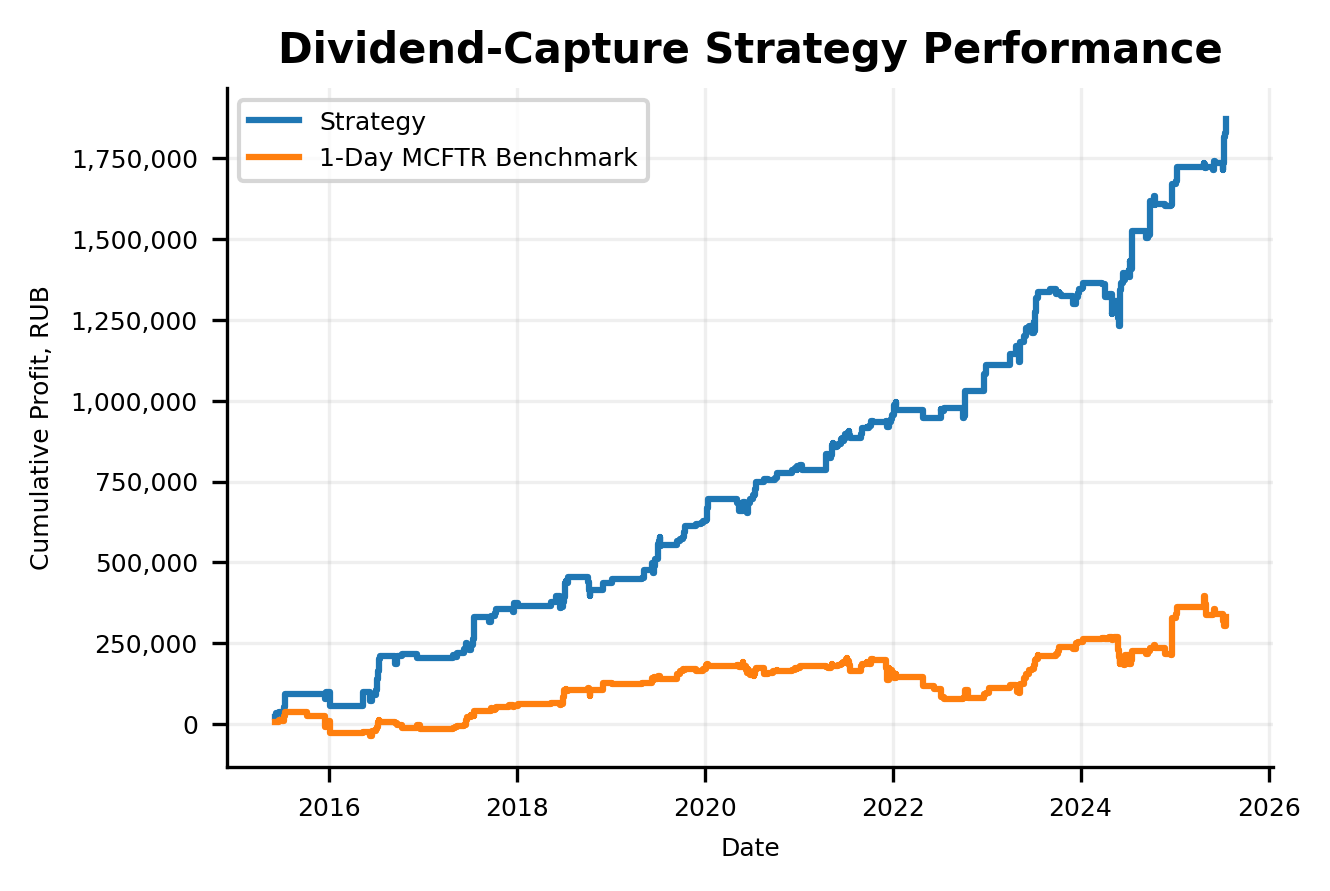

In [13]:
if __name__ == "__main__":
    trades, hist = simulate_strategy(df_dividends,commission = 0.0002)
    stats = compute_stats(trades, hist)
    # Plot result
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        print()
        print(f"Strategy stats:")
        print(stats)
    plot_cumulative_profit(hist)
    plt.show()
    #save_log(log)

In [14]:
profit_by_ticker = trades.groupby('ticker')['profit'].sum().reset_index()
profit_by_ticker = profit_by_ticker.sort_values(by='profit', ascending=False)
print("Total profit for each ticker:")
print(profit_by_ticker)

Total profit for each ticker:
   ticker     profit
17   LKOH 246,405.30
22   MOEX 138,446.56
11   FLOT 120,094.07
12   GAZP 107,537.35
46   TATN 106,586.75
51   VTBR  95,716.10
48   TRMK  93,048.93
43  SNGSP  88,171.89
41   SIBN  85,274.82
34   ROSN  83,367.69
39  SBERP  72,027.72
38   SBER  70,235.10
1    AFLT  65,712.54
10   FEES  65,059.27
23   MTSS  61,906.16
4    AMEZ  59,456.41
29   PHOR  55,399.35
40   SFIN  49,109.65
19   MAGN  47,841.32
2    AGRO  47,485.33
21   MGNT  47,473.42
16   IRAO  46,121.91
3    ALRS  45,805.88
26   NMTP  45,576.46
42   SNGS  38,134.77
28   OGKB  31,365.18
6    BELU  31,317.51
47  TATNP  25,365.27
52     X5  20,520.08
20   MDMG  20,037.76
15   HYDR  19,714.19
49  TRNFP  15,270.65
35   RTKM  14,505.95
30   PLZL  12,727.23
50   UPRO  12,134.03
53   YDEX   8,701.79
0    AFKS   6,894.90
33   RENI   4,297.31
31   POSI    -171.11
14   HEAD  -1,373.27
37   RUAL  -1,721.63
7    BSPB  -2,047.55
9    EUTR  -3,181.68
45      T  -7,331.76
44   SVCB -12,188.11
24  

### Sensitivity to fees

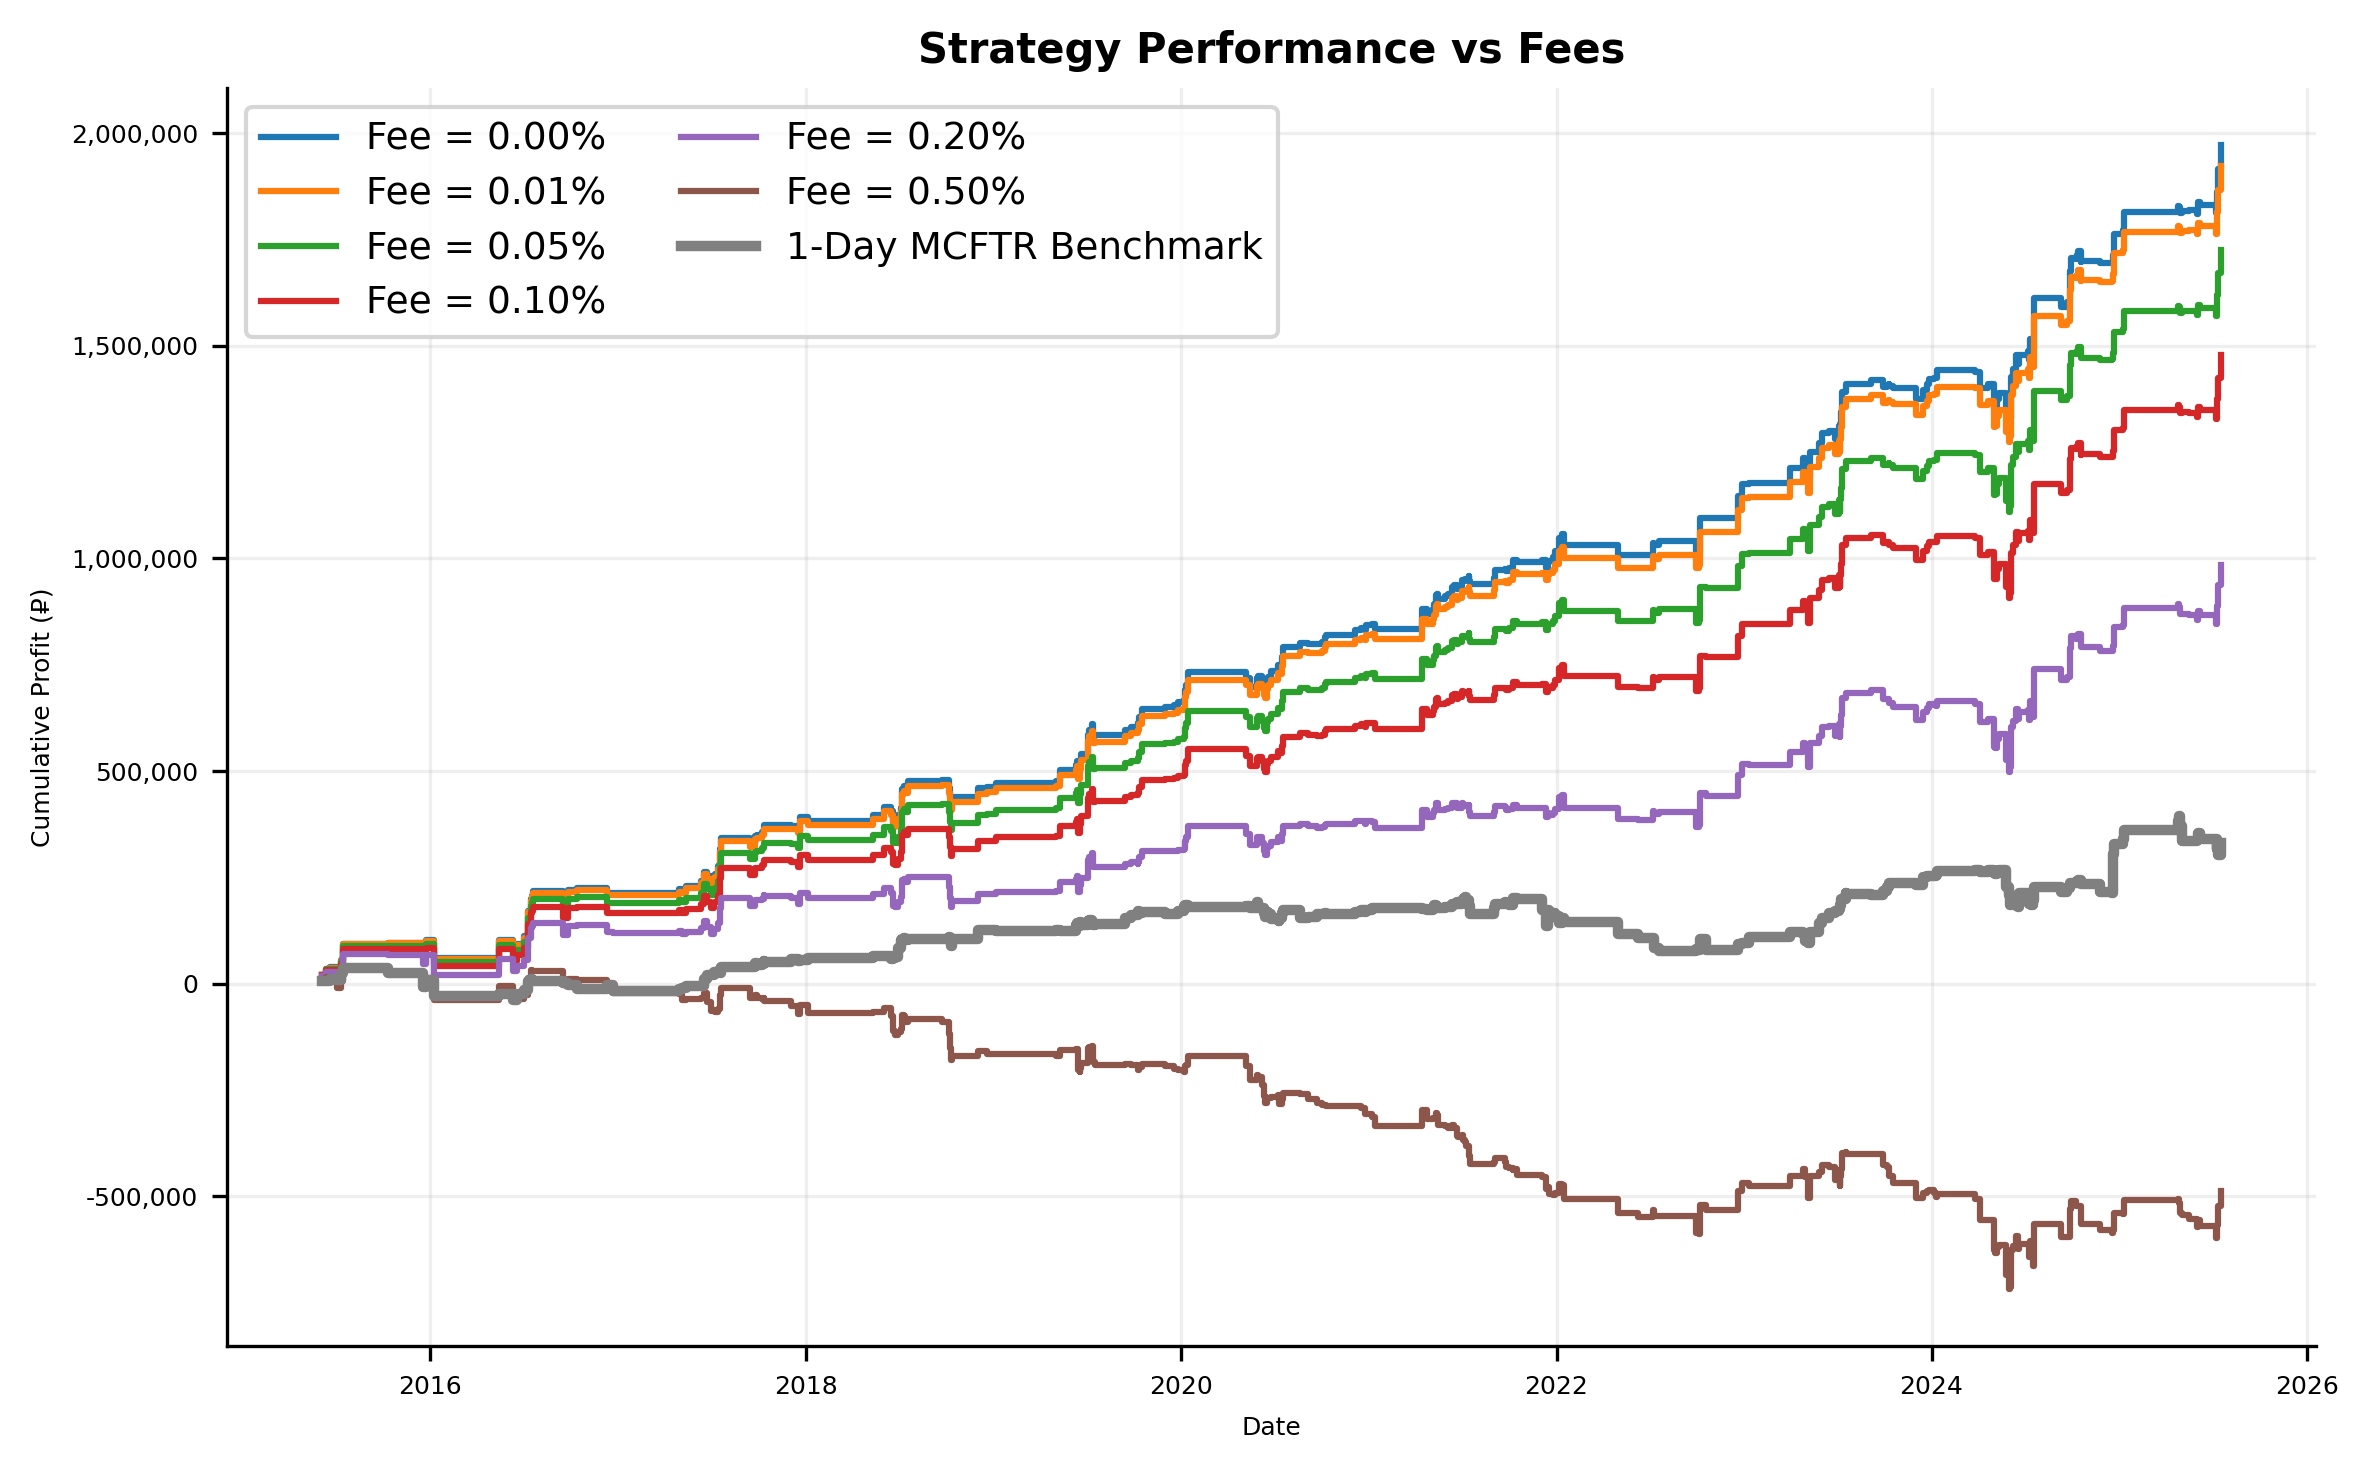

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fees = [0, 1e-4, 5e-4, 1e-3, 2e-3, 5e-3]

plt.figure(figsize=(8, 5))
plt.xlabel("Date")
plt.ylabel("Cumulative Profit (₽)")
plt.title("Strategy Performance vs Fees")

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:,.0f}"))

for fee in fees:
    _, hist = simulate_strategy(df_dividends, commission=fee)
    lw = 2.5 if abs(fee - 2e-4) < 1e-6 else 1.5 
    plt.step(hist["date"], hist["cumulative_profit"], where="post",
             label=f'Fee = {fee*100:.2f}%', linewidth=lw)

plt.step(hist["date"], hist["cumulative_bench_profit"], where="post",
         label='1-Day MCFTR Benchmark', color='grey', linewidth=2.5, linestyle='-', zorder=3)

plt.legend(ncol=2, fontsize=9)

plt.tight_layout()
save_pic('dividend_strategy_performance')
plt.show()



Sell close-close
count   333.00
mean      0.89
std       2.22
min      -6.23
5%       -2.41
25%      -0.34
50%       0.79
75%       1.89
95%       4.69
max      11.89
dtype: float64


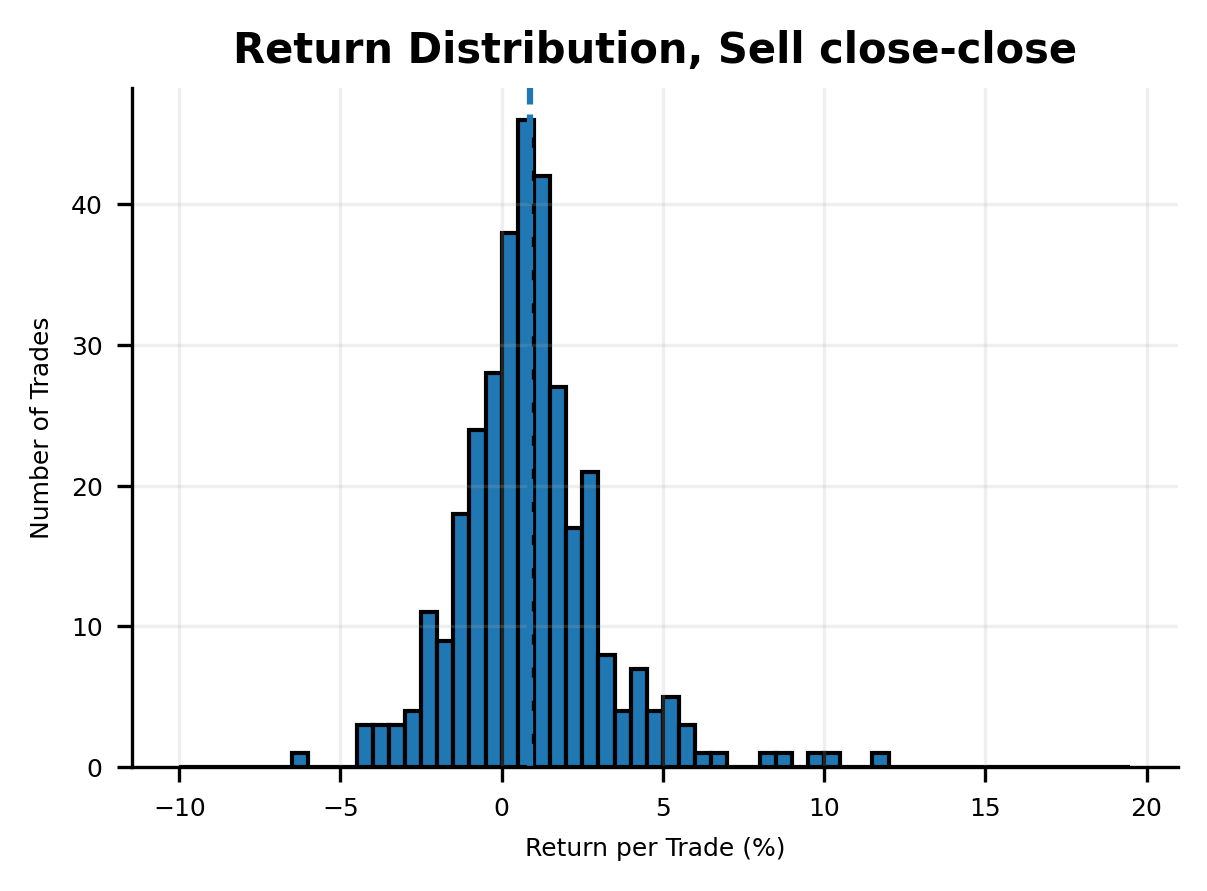

In [16]:
def simulate_div_strategy(
        df: pd.DataFrame,
        sell_price_col: str = "Close-ex",   
        buy_price_col: str = "Close",
        dividend_col: str = "Dividend, RUB",
        commission_rate: float = 0.002      
    ) -> pd.Series:
    """
    Возвращает серию с доходностями каждой сделки в процентах
    (положительные — заработок, отрицательные — убыток).
    """
    req_cols = [sell_price_col, buy_price_col, dividend_col]
    df_clean = df.dropna(subset=req_cols).copy()

    buy = df_clean[buy_price_col]
    sell = df_clean[sell_price_col]
    div  = df_clean[dividend_col]

    buy_cost      = buy  * commission_rate
    sell_cost     = sell * commission_rate

    profit_rub    = sell - sell_cost + div- (buy + buy_cost)
    return_pct    = profit_rub / (buy + buy_cost) * 100     # в процентах
    return return_pct

commission = 0.0002 
strategy_1 = simulate_div_strategy(df_dividends, sell_price_col="Open-ex",
                                   commission_rate=commission)
strategy_2 = simulate_div_strategy(df_dividends, sell_price_col="Close-ex",
                                   commission_rate=commission)

def show_stats(series, title):
    print(f"\n{title}")
    print(series.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T.round(2))
    plt.figure()
    edges = np.arange(-10, 20, 0.5)
    plt.hist(series, bins=edges, edgecolor='black')
    plt.title(f"Return Distribution, {title}")
    plt.xlabel("Return per Trade (%)")
    plt.ylabel("Number of Trades")
    plt.axvline(series.mean(), linestyle='--')
    save_pic(f'return_distribution_{title.lower().replace(" ", "_")}')
    plt.show()


show_stats(strategy_2, "Sell close-close")


<ipython-input-17-13c339b23acd>:45: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="Average Return (%)")


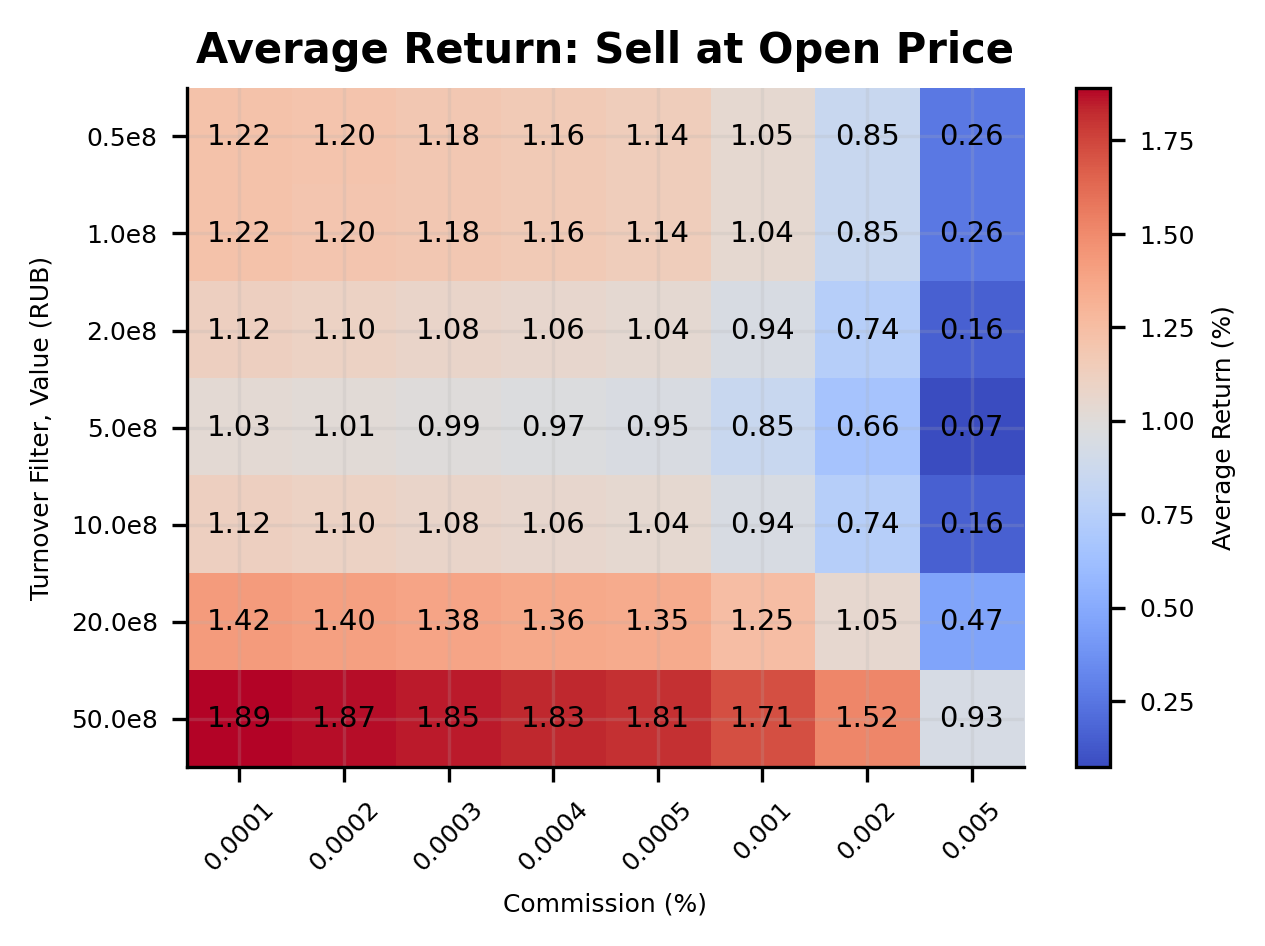

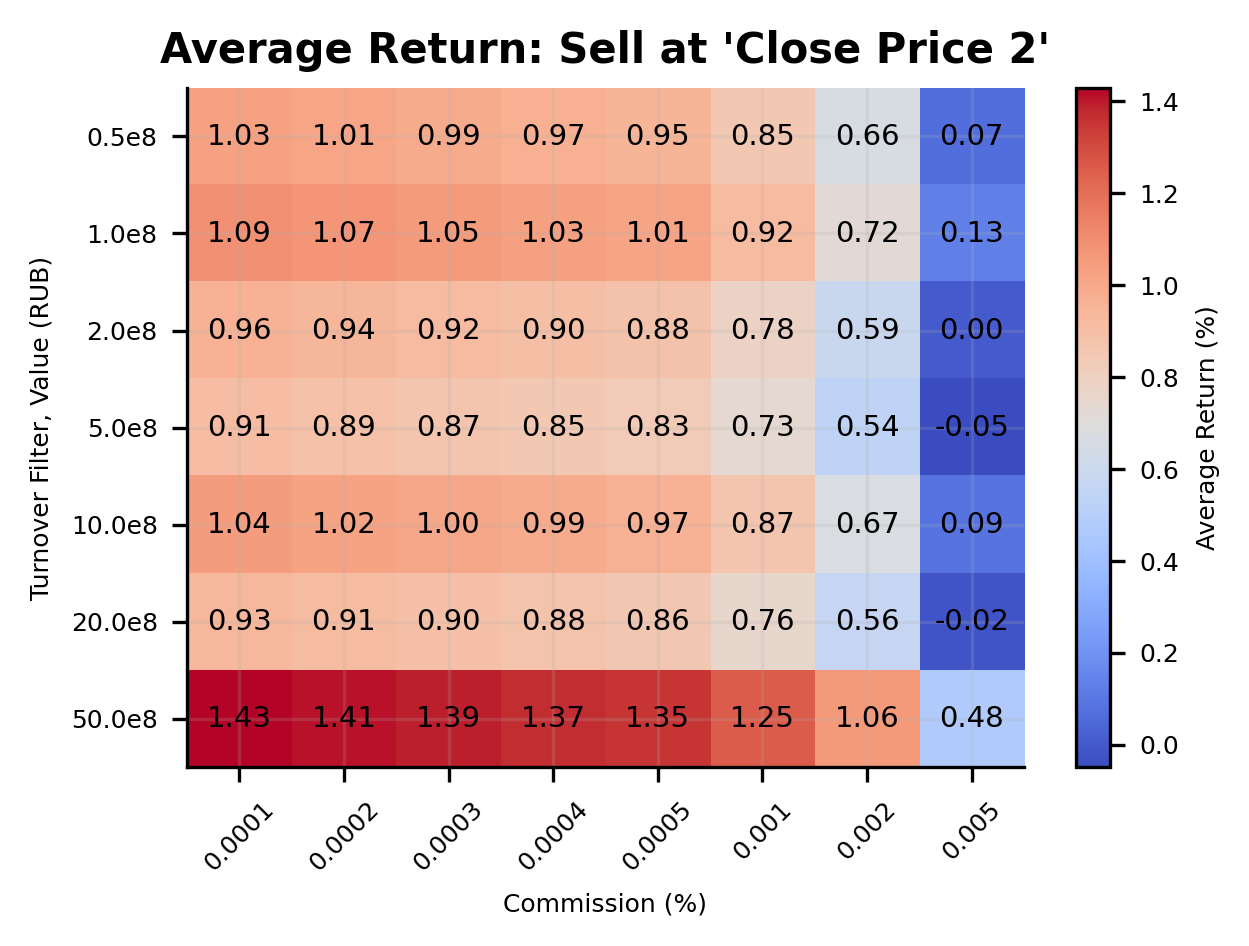

In [17]:
values = [0.5e8, 1e8, 2e8, 5e8, 10e8, 20e8, 50e8]         
fees   = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001,
          0.002, 0.005]                                    

n_val, n_fee = len(values), len(fees)

heat_open   = np.full((n_val, n_fee), np.nan)   
heat_close2 = np.full((n_val, n_fee), np.nan)  


for i, val in enumerate(values):
    df_val = df_dividends_0[df_dividends_0['Last buy day']>dt.datetime(2015, 1, 1)].copy()
    df_val = df_val[df_val['Объём, руб']>=val]
    for j, fee in enumerate(fees):
        strat_open = simulate_div_strategy(df_val,
                                           sell_price_col="Открытие1",
                                           buy_price_col = "Закрытие0",
                                           dividend_col = "Дивиденд, руб",
                                           commission_rate=fee)
        strat_close2 = simulate_div_strategy(df_val,
                                             sell_price_col="Закрытие1",
                                           buy_price_col = "Закрытие0",
                                           dividend_col = "Дивиденд, руб",
                                             commission_rate=fee)
        heat_open[i, j]   = strat_open.mean()    if not strat_open.empty   else np.nan
        heat_close2[i, j] = strat_close2.mean()  if not strat_close2.empty else np.nan


def plot_heatmap(data, title):
    plt.figure()
    im = plt.imshow(data, aspect='auto', cmap='coolwarm')

    plt.xticks(np.arange(n_fee), fees, rotation=45)
    plt.yticks(np.arange(n_val), [f"{v/1e8:.1f}e8" for v in values])
    plt.xlabel("Commission (%)")
    plt.ylabel("Turnover Filter, Value (RUB)")
    plt.title(title)

    for i in range(n_val):
        for j in range(n_fee):
            val = data[i, j]
            if not np.isnan(val):
                plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=7)

    plt.colorbar(label="Average Return (%)")
    save_pic(title.lower().replace(" ", "_"))
    plt.show()


plot_heatmap(heat_open,   "Average Return: Sell at Open Price")
plot_heatmap(heat_close2, "Average Return: Sell at 'Close Price 2'")
